In [48]:
from qutip import *
from qutip.qip.device import Processor
import numpy as np
import matplotlib.pyplot as plt
import sympy
from copy import deepcopy
from scipy.interpolate import CubicHermiteSpline
import random

In [49]:
# defines the letters used later as sympy symbols
x,A,ω,φ,y0,μ,Γ,M,A_DRAG = sympy.symbols("x,A,ω,φ,y0,μ,Γ,M,A_DRAG")

# window function for a Blackman pulse
# func is a sympy symbolic expression
def window(func):
    return sympy.Piecewise(
        (0, x>μ+M/2),
        (0, x<μ-M/2),
        (func, True)
    )

# shape functions

sinusoid_sym = A*sympy.cos(ω*x-φ)+y0

# CHECK THE SHIFTS FOR THE DRAG ADDITIONS
# for Gaussian it's pi/2, but for Blackman M/2 seems to work instead?

gaussian_sym = A*sympy.exp((-4*np.log(2)*((x-μ)**2))/(Γ**2))
gaussian_sym += A_DRAG * sympy.diff(gaussian_sym, x).subs(x, x-sympy.pi/2)

blackman_sym = A*(1-(0.42 - 0.5 * sympy.cos(2*sympy.pi*(x-μ)/M) + 0.08 * sympy.cos(4*sympy.pi*(x-μ)/M)))
blackman_sym = window(blackman_sym + A_DRAG * sympy.diff(blackman_sym, x).subs(x, x-M/2))

# converts the symbolic expressions to actual functions

sinusoid_func = sympy.lambdify([x,A,ω,φ,y0], sinusoid_sym, "numpy")
gaussian_func = sympy.lambdify([x,A,μ,Γ,A_DRAG], gaussian_sym, "numpy")
blackman_func = sympy.lambdify([x,A,μ,M,A_DRAG], blackman_sym, "numpy")

# sinusoid
def sinusoid(x_val,A_val,ω_val,φ_val,y0_val):
    return sinusoid_func(x_val,A_val,ω_val,φ_val,y0_val)

# gaussian
# not normalised
# Γ is FWHM
def gaussian(x_val,A_val,μ_val,Γ_val,A_DRAG_val=0):
    # the defaualt A_DRAG_val=0 is only for the optimum finding function, and must be specified for the actual pulse.
    return gaussian_func(x_val,A_val,μ_val,Γ_val,A_DRAG_val)

# blackman
# as defined on the numpy page
# Γ_val is the FWHM, while M is the Blackman parameter
def blackman(x_val,A_val,μ_val,Γ_val,A_DRAG_val): 
    M_val = Γ_val / 0.810957 # conversion from FWHM to Blackman parameter
    return blackman_func(x_val,A_val,μ_val,M_val,A_DRAG_val)

In [50]:
# function to calculate transition frequency
def calculate_ω(transmon, n1, n2):
    return (transmon.Ω - 0.5*transmon.α) * np.abs(n2 - n1) + 0.5 * transmon.α * (n2**2 - n1**2)

# function to calculate the level occupancy operator
def level_operator(n_levels, n):
    return basis(n_levels, n) * basis(n_levels, n).dag()

In [51]:
class transmon:

    def __init__(self, n_levels:int, initial_level:int, Ω:float=5000, α:float=-350, t_decay=None, t_dephase=None):
        
        self.n_levels = n_levels
        self.initial_level = initial_level
        self.Ω = Ω
        self.α = α
        self.t_decay = t_decay
        self.t_dephase = t_dephase

        self.ψ0 = basis(n_levels, initial_level)

        self.a = destroy(n_levels)
        self.n = self.a.dag() * self.a

In [52]:
class driver:

    def __init__(self, transmon, pulse_func, RWA):
        # pulse_func is "gaussian", "blackman", or "sinusoid"
        self.transmon = transmon
        self.pulse_func = pulse_func

        # not having RWA seems to make a significant difference: what's going wrong?
        if RWA:
            self.H0 = transmon.n*transmon.Ω + 0.5 * transmon.α * transmon.n * (transmon.n-1)
        else:
            H0 = (transmon.Ω-transmon.α)*(transmon.n+0.5) + ((transmon.Ω-transmon.α)**2)/(8*transmon.α) + (transmon.α*(transmon.a+transmon.a.dag())**4)/12 # worth going to higher order terms?

        self.H1 = transmon.a + transmon.a.dag()
        self.H1_coeffs = self.__make_H1_coeffs__()

    def __make_H1_coeffs__(self):

        if self.pulse_func == "gaussian":
            def H1_coeffs(t, args):
                A,μ,Γ,ω,A_DRAG = args["A"],args["μ"],args["Γ"],args["ω"],args["A_DRAG"]
                return sinusoid(t,1,ω,ω*μ,0) * gaussian(t,A,μ,Γ,A_DRAG)

        elif self.pulse_func == "blackman":
            def H1_coeffs(t, args):
                A,μ,Γ,ω,A_DRAG = args["A"],args["μ"],args["Γ"],args["ω"],args["A_DRAG"]
                return sinusoid(t,1,ω,ω*μ,0) * blackman(t,A,μ,Γ,A_DRAG)
            
        elif self.pulse_func == "sinusoid":
            def H1_coeffs(t, args):
                A,ω,φ,y0 = args["A"],args["ω"],args["φ"],args["y0"]
                return sinusoid(t,A,ω,φ,y0)                

        else:
            raise ValueError("pulse_func must be gaussian, blackman, or sinusoid.")
                
        return H1_coeffs

In [53]:
def propagate(transmon, driver, t, args, plot):

    e_ops = [level_operator(transmon.n_levels, i) for i in range(transmon.n_levels)]

    H1_coeffs = driver.H1_coeffs(t, args)

    p = Processor(N=1, t1=transmon.t_decay, t2=transmon.t_dephase, dims=[transmon.n_levels], spline_kind="cubic")

    p.add_drift(driver.H0, 0)
    p.add_control(driver.H1)

    p.pulses[0].tlist = t
    p.pulses[0].coeff = H1_coeffs

    ψt = p.run_state(transmon.ψ0, e_ops=e_ops)

    ψt = ψt.expect

    if plot: 

        p.plot_pulses()
        plt.show()

        [plt.plot(t, i) for i in ψt]
        plt.legend(["n="+str(i) for i in range(0, len(ψt))])
        plt.xlabel("Time [what units?]")
        plt.ylabel("Probability")
        plt.title(", ".join([i + ": " + str(round(args[i],5)) for i in args])) # slicing to get rid of {} in output
        plt.show()

        _, ax = plt.subplots()
        dat = ax.bar([i for i in range(len(ψt))], [round(i[-1], 5) for i in ψt])
        ax.bar_label(dat)
        plt.xticks([i for i in range(len(ψt))], ["n="+str(i) for i in range(len(ψt))])
        plt.title("Final level probabilities")
        plt.xlabel("Energy level")
        plt.ylabel("Probability")
        plt.show()

    return ψt

In [54]:
def optimize_parameter(transmon, driver, args, t, target_level, parameter, semirange, N, fidelity_only, plot=False):

    # if parameter not in ["A", "ω"]:
    #     raise NotImplementedError
    
    args_tmp = deepcopy(args)

    #test_values = np.linspace(np.clip(args[parameter]-semirange,0, None), args[parameter]+semirange, 101)

    test_values = np.linspace(args[parameter]-semirange, args[parameter]+semirange, N)

    fidelities = []

    for i in test_values:
        args_tmp[parameter] = i
        expected = propagate(transmon, driver, t, args_tmp, False)
        fidelities.append(expected[target_level][-1])

    fidelity_func = CubicHermiteSpline(test_values, fidelities, np.gradient(fidelities, test_values))

    if fidelity_only:
        return fidelity_func
    
    # find the highest turning point in range
    cr_pts = [i for i in fidelity_func.derivative().roots() if i >= test_values[0] and i <= test_values[-1]]

    if len(cr_pts) == 0:
        args_tmp[parameter] = test_values[np.argmax(fidelities)]
        print("No optimum found, optimal value set to upper end of test values. Rerun with altered parameters.")

    else:
        args_tmp[parameter] = cr_pts[np.argmax(fidelity_func(cr_pts))]  

    if plot:

        plt.plot(test_values, fidelities)
        plt.axvline(args_tmp[parameter], c='r')
        plt.xlabel(parameter)
        plt.ylabel("Fidelity")
        plt.title("Fidelity variation with " + parameter)
        plt.show()

    return args_tmp, fidelity_func

In [66]:
def optimise_pulse(tr, d, args, t, target_level, plot=False):

    args, A_fidelity = optimize_parameter(tr, d, args, t, 1, "A", 100, 31, False, plot)

    args, ω_fidelity = optimize_parameter(tr, d, args, t, 1, "ω", 300, 31, False, plot)

    args, Γ_fidelity = optimize_parameter(tr, d, args, t, 1, "Γ", 0.005, 31, False, plot)

    args, A_DRAG_fidelity = optimize_parameter(tr, d, args, t, 1, "A_DRAG", 0.05, 31, False, plot)

    args, A_fidelity = optimize_parameter(tr, d, args, t, 1, "A", 20, 301, False, plot)

    args, ω_fidelity = optimize_parameter(tr, d, args, t, 1, "ω", 50, 301, False, plot)

    args, Γ_fidelity = optimize_parameter(tr, d, args, t, 1, "Γ", 0.001, 301, False, plot)

    args, A_DRAG_fidelity = optimize_parameter(tr, d, args, t, 1, "A_DRAG", 0.001, 301, False, plot)

    # get fidelity curves

    agrs, A_fidelity = optimize_parameter(tr, d, args, t, 1, "A", 50, 301, False, plot)

    ω_fidelity = optimize_parameter(tr, d, args, t, 1, "ω", 500, 301, True, plot)

    Γ_fidelity = optimize_parameter(tr, d, args, t, 1, "Γ", 0.001, 301, True, plot)

    A_DRAG_fidelity = optimize_parameter(tr, d, args, t, 1, "A_DRAG", 0.005, 301, True, plot)

    return args, A_fidelity, ω_fidelity, Γ_fidelity, A_DRAG_fidelity

In [67]:
# this function calculates how noise in one of the pulse parameters affects the fidelity
# takes
# * the optimal value of the parameter
# * the fidelity function, a spline
# * the maximum amount of noise to add (maximum stdev of the gaussian distribution used to model noise added to the parameter)
# * minimum acceptable fidelity

def noise_effects(parameter:float, fidelity_func, max_noise:float, fidelity_threshold:float):

    noise_σs = np.linspace(0, max_noise, 500)
    fidelities = []

    # for each value of noise, create an array with that much noise around the optimal value, and calculate the average fidelity
    for σ in noise_σs:
        noisy_values = parameter + np.random.normal(0, σ, 2000)
        fidelities.append(np.average(fidelity_func(noisy_values)))

    # calculate the maximum noise threshold to achieve some fidelity
    try:
        max_noise_threshold = noise_σs[np.where(np.array(fidelities)>=fidelity_threshold)[0][-1]]
    except Exception as e:
        raise RuntimeError("The desired fidelity is never achieved. Try re-running optimisation.") from e

    print("Max noise threshold to achieve " + str(fidelity_threshold) + " fidelity is σ = " + str(max_noise_threshold) + ". ")

    plt.plot(noise_σs, fidelities)
    plt.axhline(fidelity_threshold)
    plt.axvline(max_noise_threshold)
    plt.ylabel("Fidelity")
    plt.xlabel("Noise [σ]")
    plt.ylim(2*fidelity_threshold-1, 1)
    plt.title("Fidelity variation")
    plt.show()

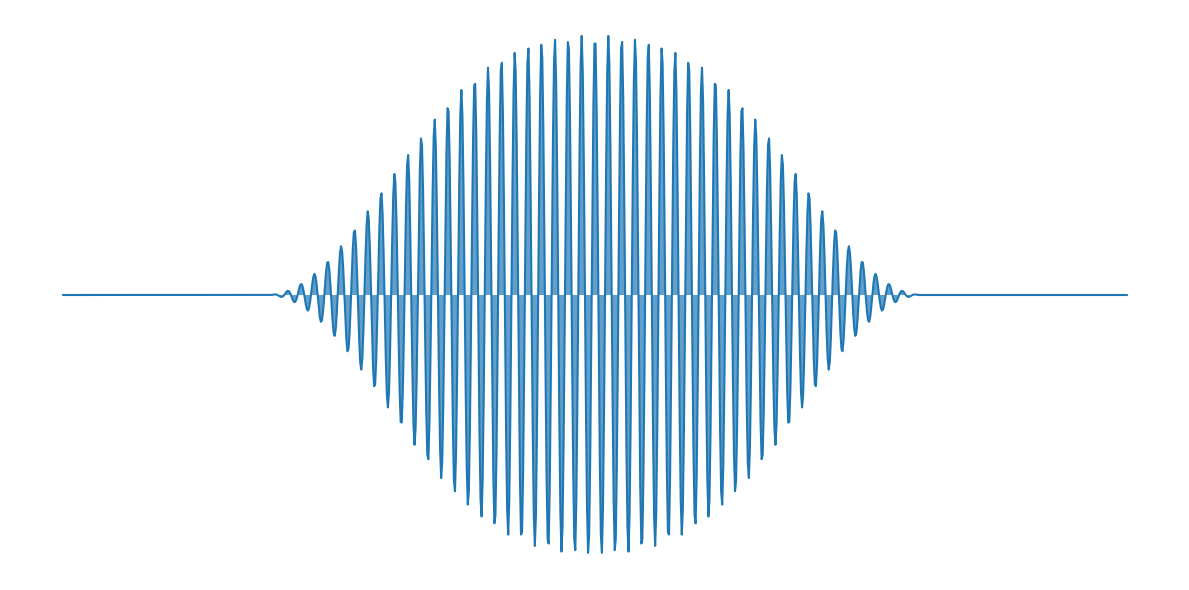

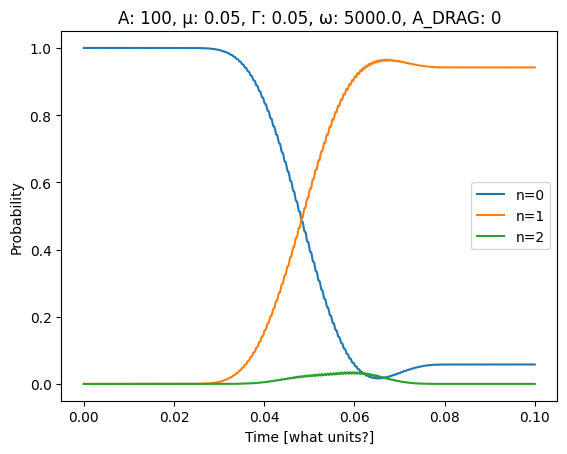

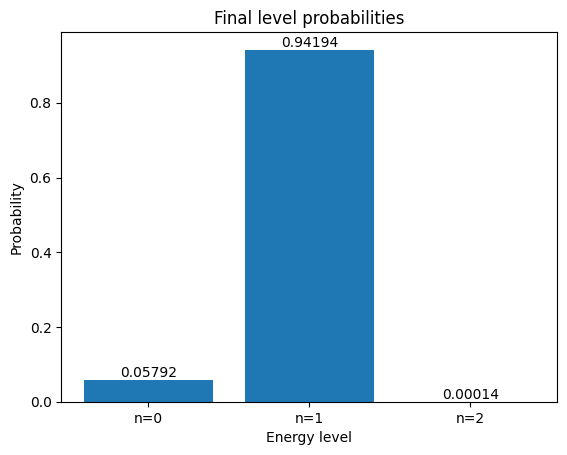

In [68]:
# Ω = random.randint(2000, 7000)
# α = random.randint(-500, -100)

tr = transmon(3, 0, 5000,-350, 100, 100)
d = driver(tr, "blackman", RWA=True)

t = np.linspace(0, 0.1, 1000)

ω = calculate_ω(tr, 0, 1)

# for gaussian/blackman
args = {"A":100,"μ":0.05,"Γ":0.05,"ω":ω,"A_DRAG":0}

# for sinusoid pulses
# args = {"A":95,"ω":ω,"φ":0,"y0":0}

expected = propagate(tr, d, t, args, True)

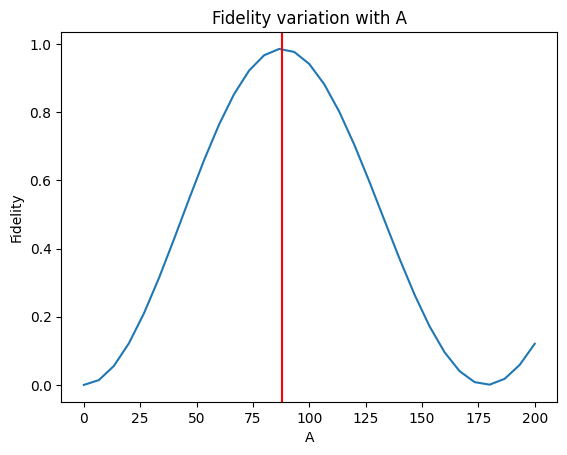

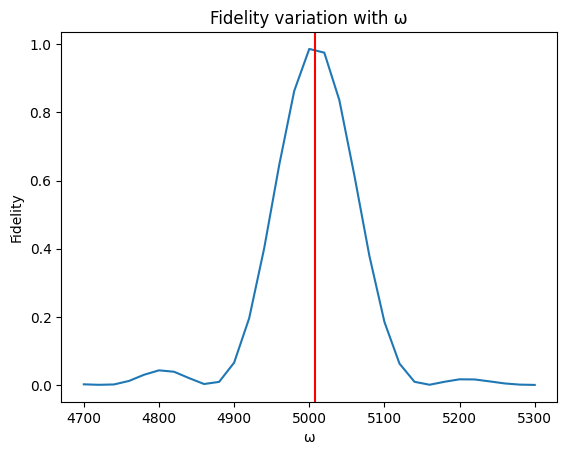

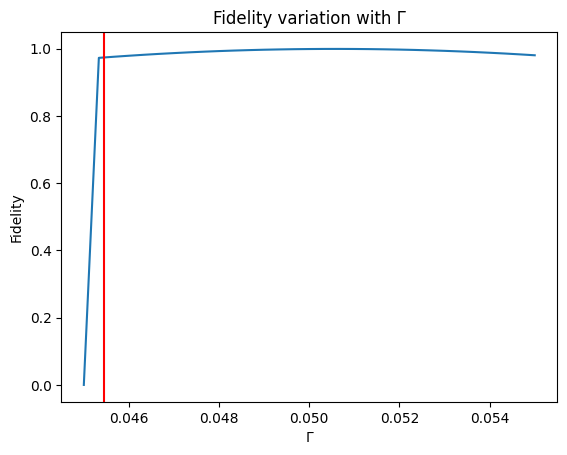

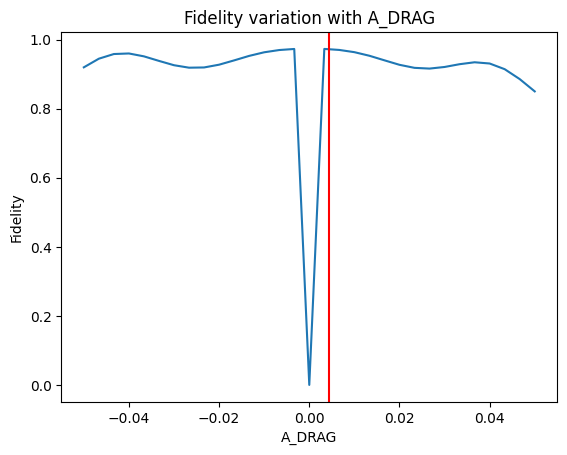

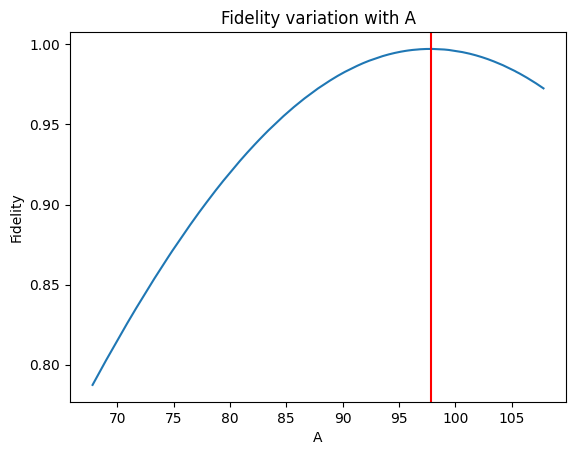

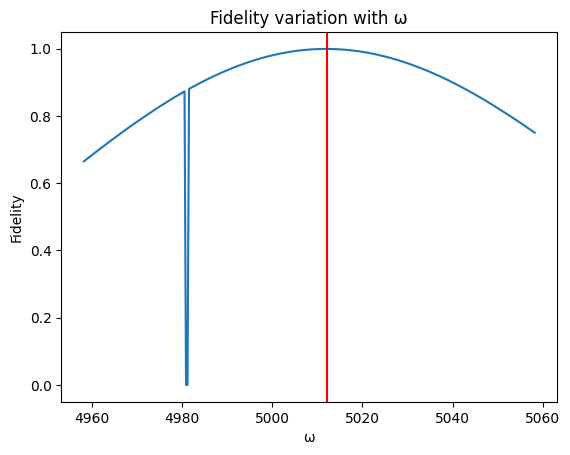

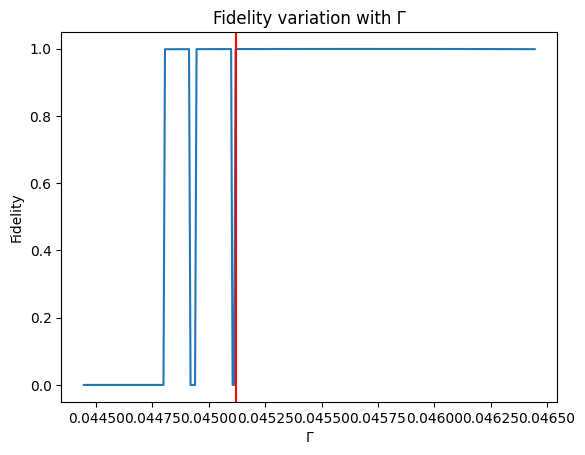

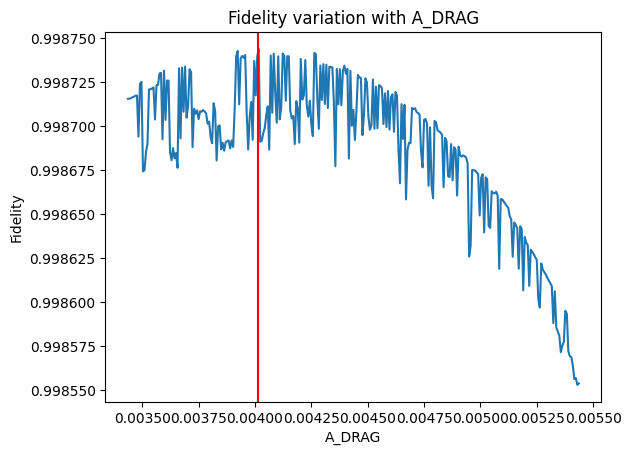

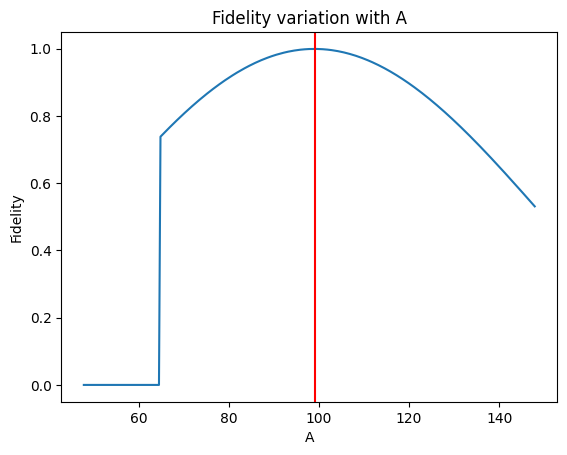

In [69]:
args, A_fidelity, ω_fidelity, Γ_fidelity, A_DRAG_fidelity = optimise_pulse(tr, d, args, t, 1, True)

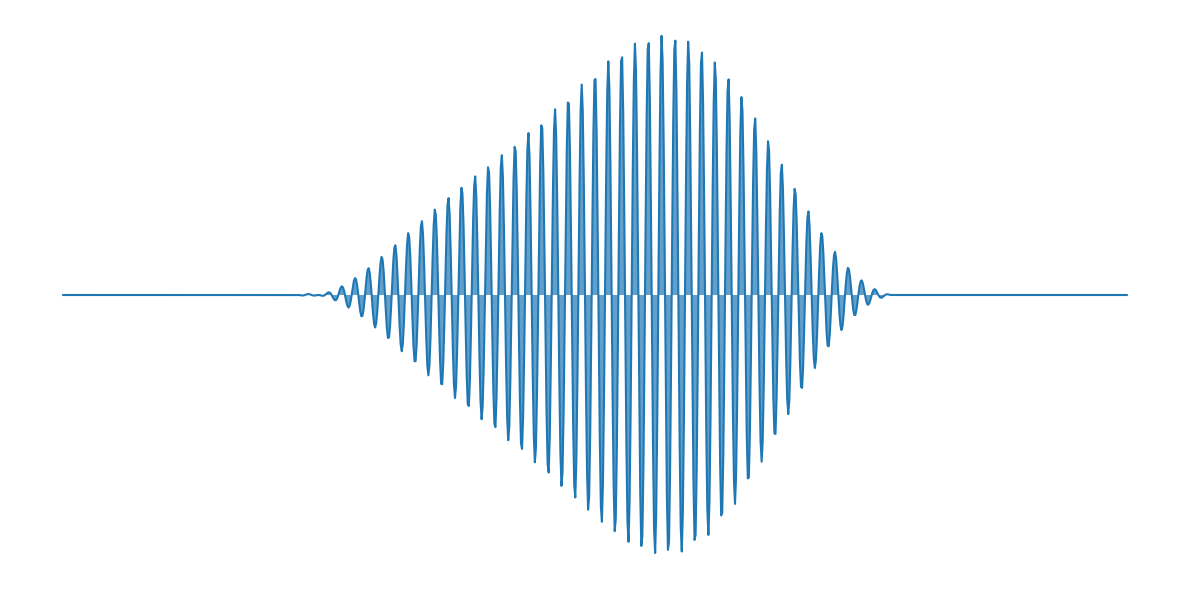

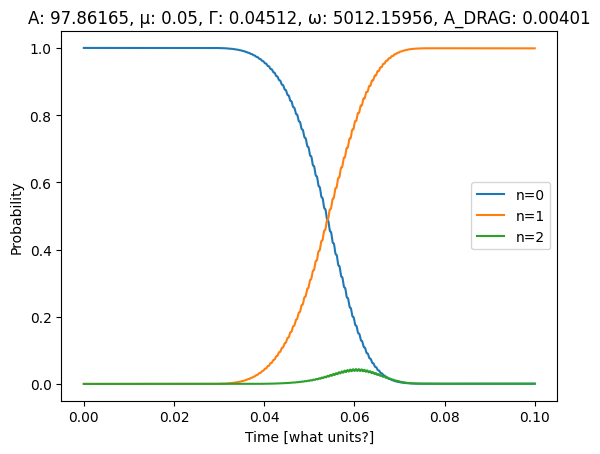

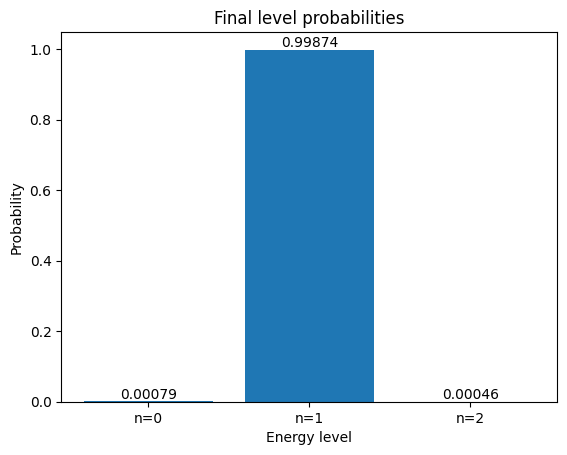

In [70]:
expected = propagate(tr, d, t, args, True)

Max noise threshold to achieve 0.99 fidelity is σ = 6.292585170340681. 


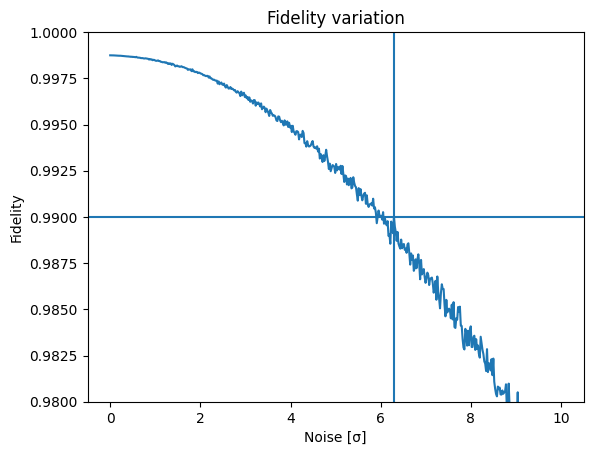

In [71]:
noise_effects(args["A"], A_fidelity, 10, 0.99)

Max noise threshold to achieve 0.99 fidelity is σ = 0.3006012024048096. 


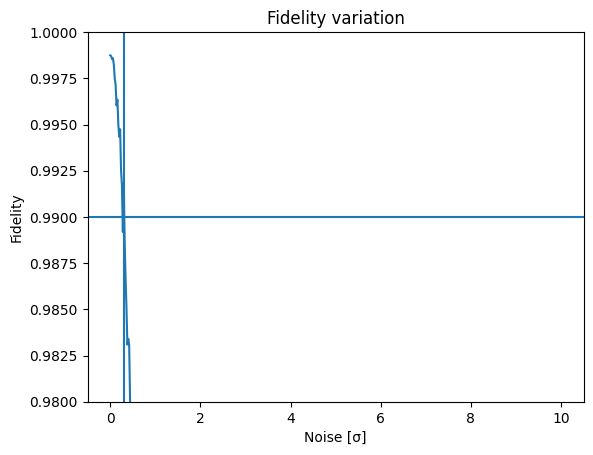

In [72]:
noise_effects(args["ω"], ω_fidelity, 10, 0.99)

Max noise threshold to achieve 0.99 fidelity is σ = 0.0. 


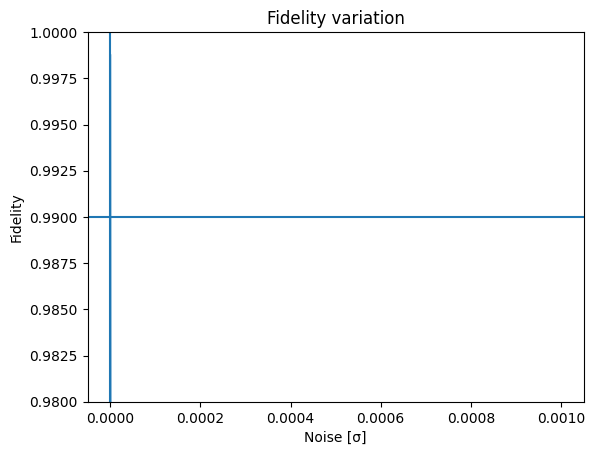

In [73]:
noise_effects(args["Γ"], Γ_fidelity, 0.001, 0.99)

Max noise threshold to achieve 0.99 fidelity is σ = 0.0007695390781563127. 


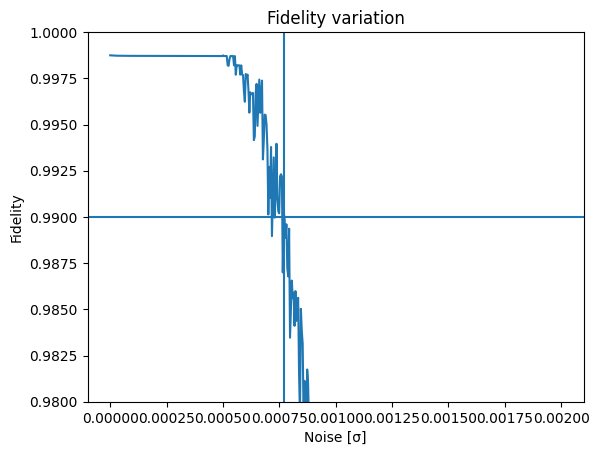

In [74]:
noise_effects(args["A_DRAG"], A_DRAG_fidelity, 0.002, 0.99)